# CH1

In [27]:
from typing import *
import os
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from IPython.display import display

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

## バンデットアルゴリズム 

,estimate,mean
0,1.288688,1.267300
1,0.591529,0.568163
2,-0.051478,-0.075528
3,1.622857,1.647389
4,-0.761210,-0.764417
5,0.260310,0.320515
6,1.084165,1.064042
7,-0.622080,-0.620409
8,-0.472379,-0.484069
9,-0.019650,0.009509


<AxesSubplot:xlabel='arm', ylabel='reward'>

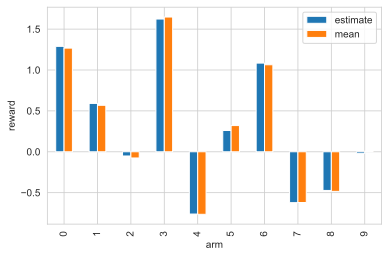

In [31]:
class Bandit:
    def __init__(self, num_arms: int) -> None:
        self.num_arms : int = num_arms
        self.means : NDArray[float] = np.random.normal(loc=0.0, scale=1.0, size=self.num_arms)

    def select(self, arm: int) -> float:
        reward : float = np.random.normal(loc=self.means[arm], scale=1.0)
        return reward


def estimate_means(bandit: Bandit, steps: int) -> List[float]:
    rewards : Dict[int, List[float]] = {arm: [] for arm in range(bandit.num_arms)}
    for _ in range(steps):
        arm : int = np.random.randint(bandit.num_arms)
        reward : float = bandit.select(arm=arm)
        rewards[arm].append(reward)
    averages : List[float] = [sum(rewards[arm]) / len(rewards[arm]) for arm in range(bandit.num_arms)]
    return averages


bandit : Bandit = Bandit(num_arms=10)
estimates : List[float] = estimate_means(bandit=bandit, steps=10000)

df : pd.DataFrame = pd.DataFrame({
    'estimate': estimates,
    'mean': bandit.means})
display(df)
df.plot(kind='bar', xlabel='arm', ylabel='reward')

## 活用と探索

【アクションの種類】
* **活用（Exploitation）**: 現時点の推定に基づいてベストを思われるアクションを選択すること
* **探索（Exploration）**: ランダムなアクションで環境の情報を収集すること

$\varepsilon$-greedyポリシー: アクションを、確率$\varepsilon$で探索、確率$(1 - \varepsilon)$で活用を選択する

,ε=1.0,ε=0.5,ε=0.1
0,0.710928,0.159568,-0.551073
1,1.117314,1.811772,-1.747556
2,2.934995,1.502836,-0.510373
3,2.211971,2.223093,-0.171402
4,0.650585,0.217988,-1.504994
...,...,...,...
495,25.638557,170.319929,224.448207
496,27.776887,169.325362,224.752106
497,27.314564,171.499856,224.409868
498,28.363456,172.420662,225.124639


<AxesSubplot:xlabel='step', ylabel='total rewards'>

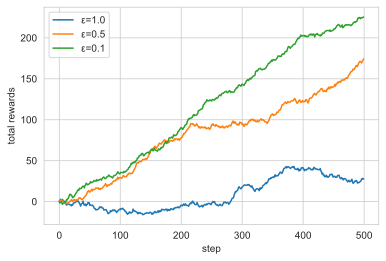

In [34]:
def get_action(means: List[float], epsilon: float) -> int:
    if np.random.random() < epsilon:
        return np.random.randint(len(means))
    else:
        return np.argmax(means)


def episode(bandit: Bandit, epsilon: float, steps: int) -> NDArray[float]:
    rewards : List[float] = [0] * steps
    means : List[float] = [0] * bandit.num_arms
    counts : List[int] = [0] * bandit.num_arms

    for step in range(steps):
        arm : int = get_action(means=means, epsilon=epsilon)
        reward : float = bandit.select(arm=arm)
        rewards[step] = reward
        counts[arm] += 1
        means[arm] += (reward - means[arm]) / counts[arm]
        
    return np.cumsum(rewards)


bandit = Bandit(num_arms=10)
rewards : Dict[str, NDArray[float]] = {f'ε={epsilon}': episode(bandit, epsilon, 500) for epsilon in [1.0, 0.5, 0.1]}

df : pd.DataFrame = pd.DataFrame(rewards)
display(df)

df.plot(xlabel='step', ylabel='total rewards')

## ハイパーパラメータチューニング

total rewardが最大となる、確率 $\varepsilon$ をグリッドサーチで求める

,ε=0.0,ε=0.1,ε=0.2,ε=0.3,ε=0.4,ε=0.5,ε=0.6,ε=0.7,ε=0.8,ε=0.9,ε=1.0
0,350.841685,818.438276,270.356894,954.821142,512.386153,151.215916,524.230548,169.618807,78.142401,4.571075,-89.670509
1,677.227063,292.296872,189.997193,749.998313,465.615169,478.701248,22.632922,49.810920,319.403409,-80.558203,221.565651
2,673.411269,791.711312,859.804859,584.453690,604.718566,365.634114,339.902144,242.982387,151.460728,244.898277,-75.055807
3,223.952290,634.827916,324.227118,560.958721,247.622082,186.866987,555.154355,253.906110,261.118559,15.192287,-102.578856
4,563.816510,918.331851,478.398388,397.076403,626.430781,330.690942,274.828742,606.865376,5.340961,584.059039,-211.011800
...,...,...,...,...,...,...,...,...,...,...,...
495,890.762570,481.295225,462.835631,517.908562,543.756935,250.360107,367.648765,138.557135,9.111749,241.257048,-7.643943
496,514.384552,958.546413,444.407169,399.061965,294.195069,154.135228,111.565086,216.174834,17.442750,18.468013,208.381223
497,307.902209,872.843140,213.670668,953.555059,727.445975,780.603294,386.899909,182.624347,2.210716,-185.549823,338.998851
498,1111.334127,558.170362,845.916753,559.039653,409.871564,191.171026,302.407501,494.745538,202.591014,15.778020,208.654719


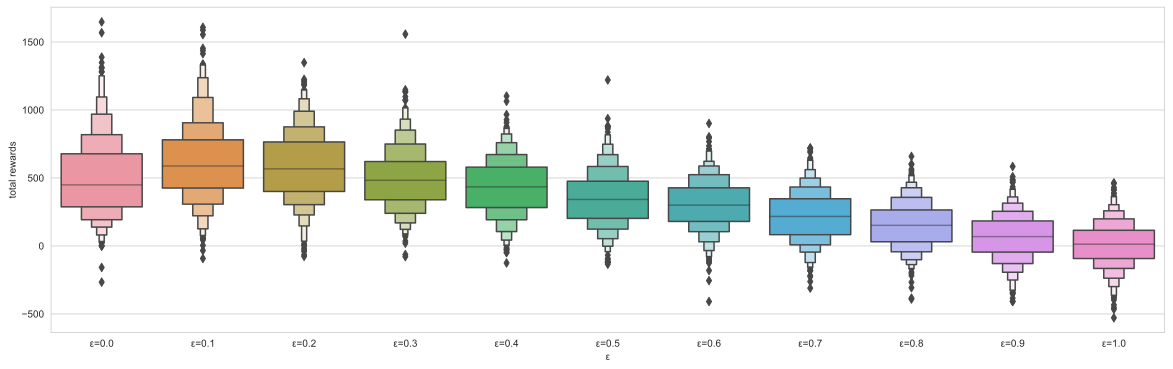

In [44]:
def hypertune(epsilons: List[float], num_samples: int) -> None:
    rewards : Dict[str, List[float]] = {}
    for epsilon in epsilons:
        scores : List[float] = [episode(Bandit(10), epsilon, 500)[-1] for _ in range(num_samples)]
        rewards[f'ε={epsilon:.1f}'] = scores

    df : pd.DataFrame = pd.DataFrame(rewards)
    display(df)
    plt.figure(figsize=(20, 6))
    sns.boxenplot(data=df)
    plt.xlabel('ε')
    plt.ylabel('total rewards')


hypertune(epsilons=np.linspace(0, 1.0, 11), num_samples=500)

## 非定常状態

,α=0,α=0.1,α=0.5,α=0.9
0,-0.453451,-0.473348,-0.093866,0.620801
1,-1.016585,0.244040,-1.858956,1.048525
2,-1.620831,0.850473,-1.746552,2.121227
3,-1.298821,0.760174,-0.558165,2.501827
4,-0.955136,1.632188,-0.133713,3.483902
...,...,...,...,...
1995,358.942950,361.814570,655.769391,369.350105
1996,358.627519,363.048071,656.885526,368.876140
1997,358.037957,361.594130,659.477006,370.113337
1998,359.886792,361.877475,659.906439,370.731212


<AxesSubplot:xlabel='step', ylabel='total reward'>

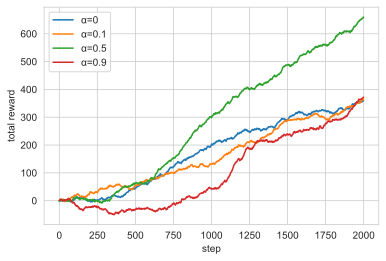

In [47]:
class Bandit:
    def __init__(self, num_arms: int) -> None:
        self.num_arms = num_arms
        self.means : NDArray[float] = np.zeros(self.num_arms)  # 期待値の初期値は0

    def select(self, arm: int) -> float:
        reward : float = np.random.normal(loc=self.means[arm], scale=1.0)
        self.means += np.random.normal(loc=0.0, scale=0.01, size=self.num_arms)  # 期待値をランダムに変動
        return reward


def episode(bandit: Bandit, alpha: float, steps: int) -> NDArray[float]:
    rewards : List[float] = [0] * steps
    means : List[float] = [0] * bandit.num_arms
    counts : List[int] = [0] * bandit.num_arms

    for step in range(steps):
        arm : int = get_action(means=means, epsilon=0.1)
        reward : float = bandit.select(arm=arm)
        rewards[step] = reward
        if alpha == 0:
            counts[arm] += 1
            means[arm] += (reward - means[arm]) / counts[arm]
        else:
            means[arm] += alpha * (reward - means[arm])
            
    return np.cumsum(rewards)


rewards : Dict[str, List[float]] = {f'α={alpha}': episode(Bandit(10), alpha, 2000) for alpha in [0, 0.1, 0.5, 0.9]}
df : pd.DataFrame = pd.DataFrame(rewards)
display(df)
df.plot(xlabel='step', ylabel='total reward')


## ハイパーパラメータチューニング（非定常状態）

,α=0.0,α=0.1,α=0.2,α=0.3,α=0.4,α=0.5,α=0.6,α=0.7,α=0.8,α=0.9,α=1.0
0,273.156855,411.678627,825.926006,381.310007,668.592025,-171.864620,166.743474,41.652923,417.576062,24.630842,565.860487
1,612.044979,1180.089414,567.763356,271.225450,467.520428,790.026441,368.076335,170.838975,340.223261,-22.714480,89.081587
2,388.521843,460.020076,480.647026,413.129370,794.498997,866.380091,-3.264390,95.233681,-119.274423,73.384754,760.635739
3,161.867462,508.344801,471.794227,1039.417337,415.333179,120.864496,443.868827,429.898328,454.782218,296.493382,205.920838
4,694.333703,415.132788,681.443874,503.431363,338.578966,915.365341,672.085976,410.144788,303.320317,109.452332,443.289915
...,...,...,...,...,...,...,...,...,...,...,...
495,370.740652,714.785218,592.690600,244.156535,414.601718,1087.796472,-56.251966,329.877584,632.130606,6.940742,161.955001
496,902.087934,275.385079,411.929274,526.708162,313.065113,386.285781,283.237233,324.410274,245.903473,520.648921,115.800498
497,100.089267,417.252618,114.217171,91.335600,1006.674177,777.873933,159.652797,311.397269,131.193309,197.938566,320.375121
498,97.812877,827.587479,632.499726,219.544087,407.014159,279.207642,254.985838,374.459810,505.613902,162.190568,266.551094


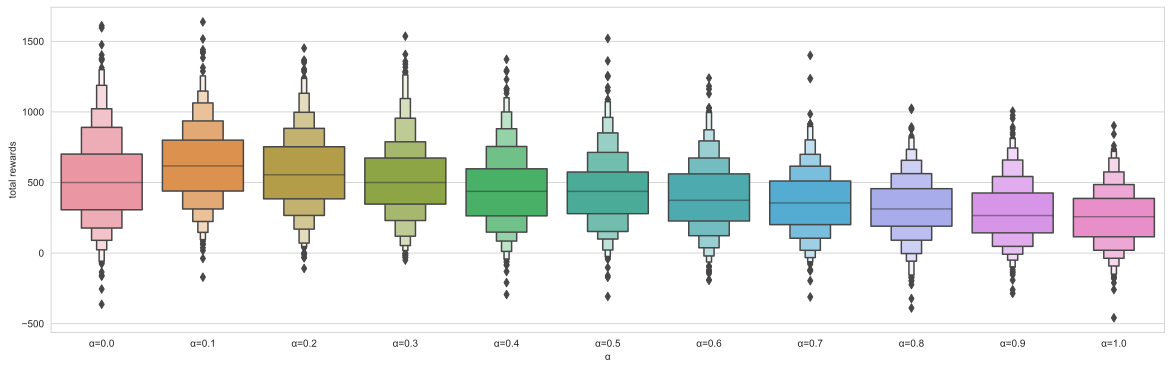

In [48]:
def hypertune(alphas: List[float], num_samples: int) -> None:
    rewards : Dict[str, List[float]] = {}
    for alpha in alphas:
        scores : List[float] = [episode(Bandit(10), alpha, 2000)[-1] for _ in range(num_samples)]
        rewards[f'α={alpha:.1f}'] = scores

    df : pd.DataFrame = pd.DataFrame(rewards)
    display(df)
    plt.figure(figsize=(20, 6))
    sns.boxenplot(data=df)
    plt.xlabel('α')
    plt.ylabel('total rewards')


hypertune(np.linspace(0, 1.0, 11), 500)

## 初期値の影響

,0,1,2,3,4,5,6,7,8,9
0,3.000000,3.000000,3.000000,2.660290,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
1,2.597479,3.000000,3.000000,2.660290,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
2,2.597479,2.580012,3.000000,2.660290,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
3,2.597479,2.580012,2.448788,2.660290,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
4,2.597479,2.580012,2.448788,2.660290,2.655027,3.000000,3.000000,3.000000,3.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...
995,-0.822499,-0.631555,0.431807,-0.480659,0.359213,0.217291,0.219682,0.923513,0.836469,1.574021
996,-0.822499,-0.631555,0.431807,-0.480659,0.359213,0.217291,0.219682,0.923513,0.836469,1.519025
997,-0.822499,-0.631555,0.431807,-0.480659,0.359213,0.217291,0.219682,0.923513,0.836469,1.444099
998,-0.822499,-0.631555,0.431807,-0.480659,0.359213,0.217291,0.219682,0.923513,0.836469,1.566712


,0,1,2,3,4,5,6,7,8,9
0,-0.165977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.165977,-0.269886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.165977,-0.269886,-0.144472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.165977,-0.269886,-0.144472,0.032190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.165977,-0.269886,-0.144472,0.012406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
995,-1.509668,-0.941744,-0.986865,-0.710744,-0.297609,-0.319362,-0.065064,0.228742,0.958432,1.808717
996,-1.509668,-0.941744,-0.986865,-0.710744,-0.297609,-0.319362,-0.065064,0.228742,0.958432,1.731027
997,-1.509668,-0.941744,-0.986865,-0.710744,-0.297609,-0.319362,-0.065064,0.228742,0.958432,1.702749
998,-1.509668,-0.941744,-0.986865,-0.710744,-0.297609,-0.319362,-0.065064,0.228742,0.958432,1.676213


<AxesSubplot:title={'center':'init reward = 0.0'}, xlabel='step', ylabel='estimate of μ'>

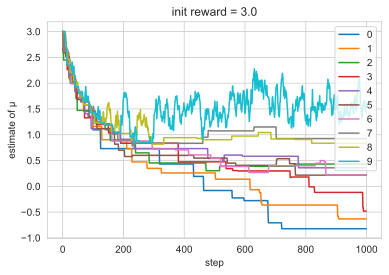

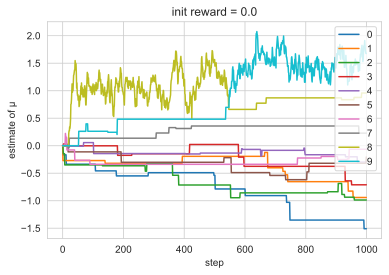

In [51]:
class Bandit:
    def __init__(self, num_arms: int) -> None:
        self.num_arms = num_arms
        self.means : NDArray[float] = np.linspace(-2, 1.5, num_arms)

    def select(self, arm: int) -> float:
        reward : float = np.random.normal(loc=self.means[arm], scale=1.0)
        return reward


def episode(bandit: Bandit, init_reward: float, steps: int) -> Dict[int, List[float]]:
    rewards : List[float] = [init_reward] * bandit.num_arms
    rewards_hist : Dict[int, List[float]] = {arm: [] for arm in range(bandit.num_arms)}

    for _ in range(steps):
        arm : int = get_action(means=rewards, epsilon=0.1)
        reward : float = bandit.select(arm=arm)
        rewards[arm] += 0.1 * (reward - rewards[arm])

        for arm in range(bandit.num_arms):
            rewards_hist[arm].append(rewards[arm])
            
    return rewards_hist


bandit = Bandit(10)

rewards_hist : Dict[int, List[float]] = episode(bandit=bandit, init_reward=3.0, steps=1000)
df : pd.DataFrame = pd.DataFrame(rewards_hist)
display(df)
df.plot(title='init reward = 3.0', xlabel='step', ylabel='estimate of μ')

rewards_hist : Dict[int, List[float]] = episode(bandit=bandit, init_reward=0.0, steps=1000)
df : pd.DataFrame = pd.DataFrame(rewards_hist)
display(df)
df.plot(title='init reward = 0.0', xlabel='step', ylabel='estimate of μ')